# Notebook 2: Select Baseline Correction Method

## Overview

This notebook helps you **evaluate and select the best baseline correction method** for your FTIR spectral data. Baseline correction is crucial for removing baseline drift and achieving flat, comparable spectra.

### What You'll Learn

1. How to apply denoising before baseline correction
2. How to define flat windows for baseline evaluation
3. How to evaluate 50+ baseline correction methods
4. How to select the best method using quantitative metrics

### Available Baseline Correction Methods

Xpectrass provides **50+ baseline correction algorithms** via pybaselines:
- **airpls, asls, arpls**: Asymmetric least squares variants
- **mor, imor, iamor**: Morphological operations
- **snip**: Statistics-sensitive non-linear iterative peak-clipping
- **poly**: Polynomial fitting
- **rubberband**: Convex hull baseline
- **and 40+ more specialized methods**

### Evaluation Metrics

Baseline correction quality is assessed using:

- **RFZN (Relative Flatness in Zero-Noise regions)**: 
  - Measures flatness in regions that should be flat
  - Lower is better (closer to 0)
  - Threshold: <0.05 recommended

- **NAR (Noise-to-Artifact Ratio)**: 
  - Measures artifacts introduced by baseline correction
  - Higher is better
  - Threshold: >0.5 recommended

- **SNR (Signal-to-Noise Ratio)**: 
  - Overall signal quality after correction
  - Higher is better
  - Threshold: >100 recommended

### Flat Windows

**Flat windows** are spectral regions that should ideally have no peaks (flat baseline). Common choices for FTIR:
- `1880-1900 cm⁻¹`: Between CO2 peaks
- `2400-2700 cm⁻¹`: Atmospheric region (if excluded)

These windows are used to evaluate how well each method achieves a flat baseline.

### Expected Output

- Visual inspection of flat windows for each polymer type
- Quantitative ranking of all baseline methods
- Excel file with detailed scores
- Top recommended method for preprocessing pipeline

---

## Step 1: Load Data and Apply Denoising

In [1]:
# Import required modules
from xpectrass import FTIRdataprocessing
from xpectrass import load_villegas_camacho_2024_c4

# Load the dataset
dataset = load_villegas_camacho_2024_c4()
print('Dataset shape:', dataset.shape)

# Define flat windows for baseline evaluation
# These are spectral regions that should ideally be flat (no peaks)
# Adjust these based on your specific FTIR data characteristics
FLAT_WINDOWS = [(1880, 1900), (2400, 2700)]

# Define the label column
LABEL_COLUMN = "type"

# Specify the denoising method to use
# (Choose this based on results from Notebook 1)
# Common choices: 'savgol', 'wavelet', 'gaussian', 'median'
DENOISING_METHOD = 'wavelet'

print(f"\nUsing denoising method: {DENOISING_METHOD}")
print(f"Flat windows for evaluation: {FLAT_WINDOWS}")
print("\nFirst few rows of data:")
print(dataset.head(5))

Dataset shape: (3000, 3741)

Using denoising method: wavelet
Flat windows for evaluation: [(1880, 1900), (2400, 2700)]

First few rows of data:
                   study sample_id  type environmental resolution  399.1927  \
0  Villegas-Camacho 2024     HDPE1  HDPE             N          H   94.7263   
1  Villegas-Camacho 2024    HDPE10  HDPE             N          H   92.5425   
2  Villegas-Camacho 2024   HDPE100  HDPE             N          H   81.2087   
3  Villegas-Camacho 2024   HDPE101  HDPE             N          H   89.2102   
4  Villegas-Camacho 2024   HDPE102  HDPE             N          H   85.7056   

   400.1569  401.1211  402.0854  403.0496  ...  3991.9265  3992.8906  \
0   94.9387   94.7092   94.2910   93.9484  ...   114.0090   113.9980   
1   93.1795   93.3965   93.3499   93.2530  ...   109.5880   109.5800   
2   83.2487   85.0425   86.4187   87.3435  ...   106.9950   107.0330   
3   89.8769   90.4785   90.9159   91.1578  ...    99.3582    99.3615   
4   87.2387   88.3298

### Important Note

**Denoising before baseline correction** is recommended because:
1. Noise can interfere with baseline estimation
2. Many baseline algorithms work better on smoothed data
3. The order matters: denoise → baseline → normalize

---

## Step 2: Initialize Pipeline and Apply Denoising

Auto-detected: Transmittance → Converting to Absorbance
########## Plotting Converted Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:03<00:00, 994.27it/s] 


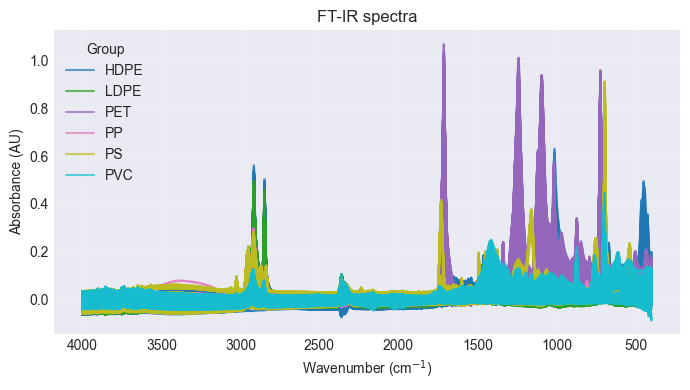

Denoising (wavelet): 100%|██████████| 3000/3000 [00:00<00:00, 11521.26it/s]
WARNING - Denoising produced 5071997 negative absorbance values (45.3% of valid points, min=-0.0852). This is physically invalid and may indicate: (1) aggressive smoothing parameters, (2) baseline drift in input data, or (3) input data already near zero. Recommendations: Apply baseline correction before denoising, or adjust denoising parameters (e.g., reduce window_length for savgol).


########## Plotting Denoised Spectra! ##########
Auto-detected: Absorbance


100%|██████████| 3000/3000 [00:03<00:00, 984.84it/s] 


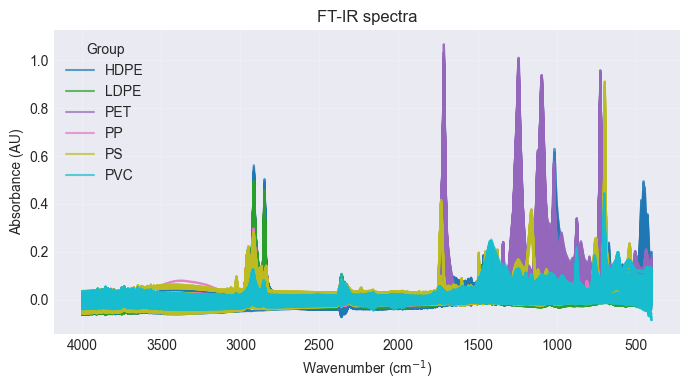


Denoised data shape: (3000, 3741)
Number of polymer types: 6


In [2]:
# Initialize the preprocessing pipeline with flat windows
# flat_windows parameter tells the pipeline which regions to use for baseline evaluation
fdp = FTIRdataprocessing(
    df=dataset,
    label_column=LABEL_COLUMN,
    flat_windows=FLAT_WINDOWS
)

# Apply denoising and convert to absorbance in one step
# This is a helper method that combines conversion + denoising
# plot=True will show before/after comparison
df_denoised = fdp._get_denoised_data(
    denoising_method=DENOISING_METHOD,
    plot=True
)

print(f"\nDenoised data shape: {df_denoised.shape}")
print(f"Number of polymer types: {df_denoised[LABEL_COLUMN].nunique()}")

---

## Step 3: Visually Inspect Flat Windows

Before evaluating baseline methods, let's verify that our chosen flat windows are appropriate by visually inspecting them for each polymer type.

### What to Look For

- **Ideally**: The region should be relatively flat with minimal peaks
- **If peaks present**: Consider adjusting the flat window ranges
- **Baseline drift**: Visible slope or curvature indicates need for baseline correction

### First Flat Window: 1880-1900 cm⁻¹

Inspecting flat window 1880-1900 cm⁻¹ for 6 polymer types

[1/6] HDPE (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 1012.32it/s]


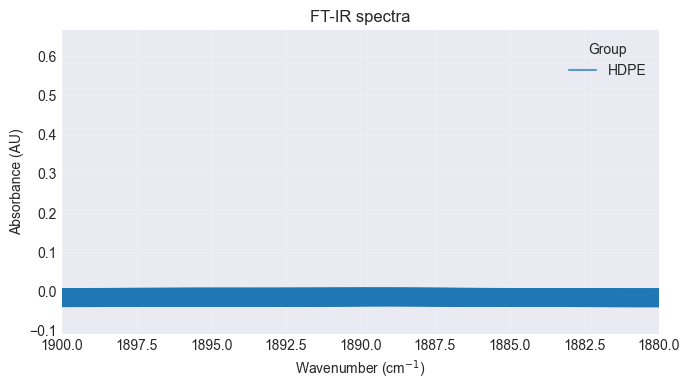

[2/6] LDPE (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 1011.55it/s]


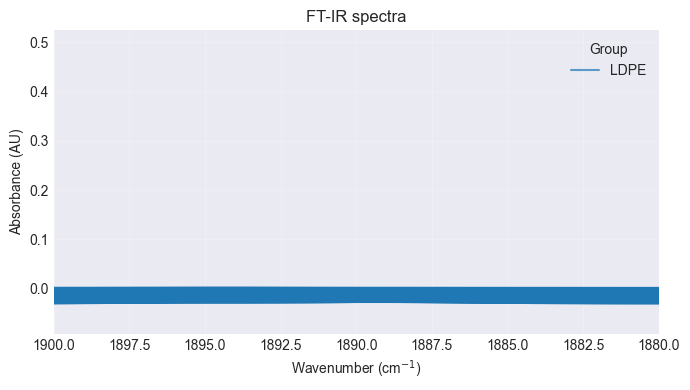

[3/6] PET (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 996.06it/s] 


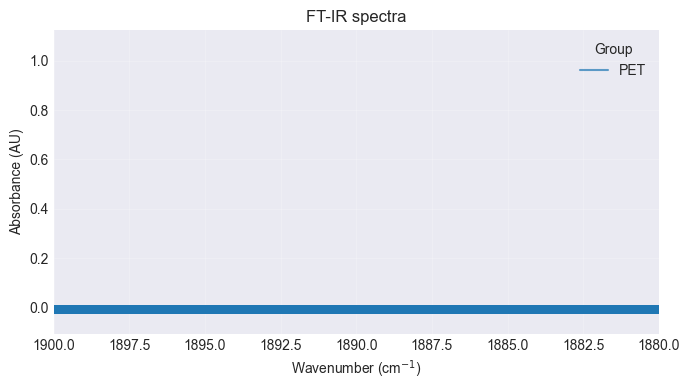

[4/6] PP (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 978.58it/s]


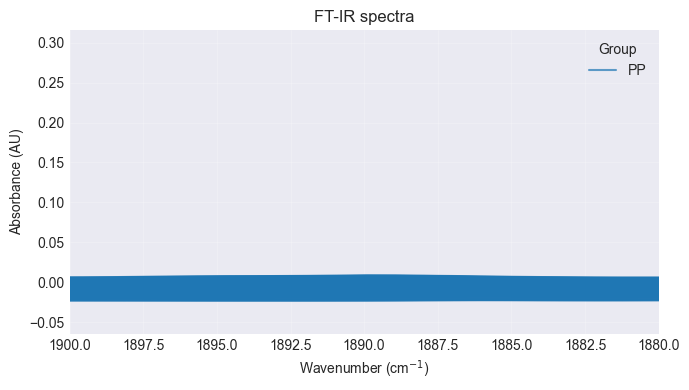

[5/6] PS (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 993.56it/s]


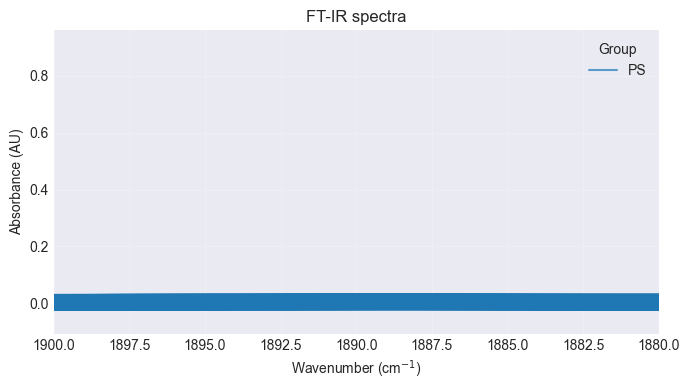

[6/6] PVC (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 994.22it/s] 


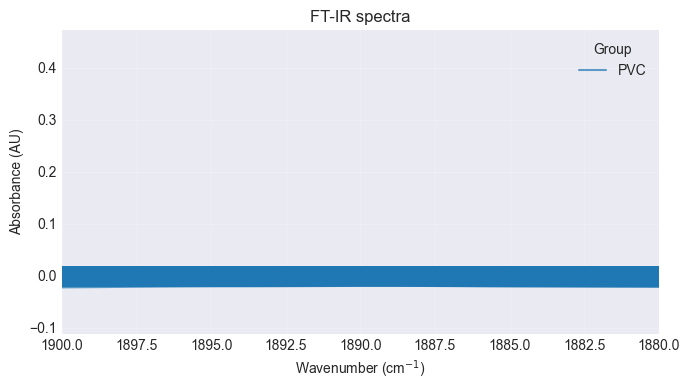

In [3]:
# Import data handling libraries
import pandas as pd
import polars as pl

# Check data format
is_polars = isinstance(df_denoised, pl.DataFrame)

# Get unique polymer types
if is_polars:
    labels = df_denoised.get_column(LABEL_COLUMN).unique().sort().to_list()
else:
    labels = df_denoised[LABEL_COLUMN].sort_values().unique().tolist()

print(f"Inspecting flat window 1880-1900 cm⁻¹ for {len(labels)} polymer types\n")

# Plot each polymer type separately in the first flat window
for i, label in enumerate(labels, 1):
    # Filter data for current polymer type
    if is_polars:
        df_label = df_denoised.filter(pl.col(LABEL_COLUMN) == label)
    else:
        df_label = df_denoised[df_denoised[LABEL_COLUMN] == label]
    
    print(f"[{i}/{len(labels)}] {label} ({len(df_label)} samples)")
    
    # Plot spectra in the flat window region
    fdp.plot(
        data=df_label,
        show_legend=True,
        color_by_group=True,
        x_min=1880,
        x_max=1900
    )

### Second Flat Window: 2400-2700 cm⁻¹

Inspecting flat window 2400-2700 cm⁻¹ for 6 polymer types

[1/6] HDPE (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 872.06it/s]


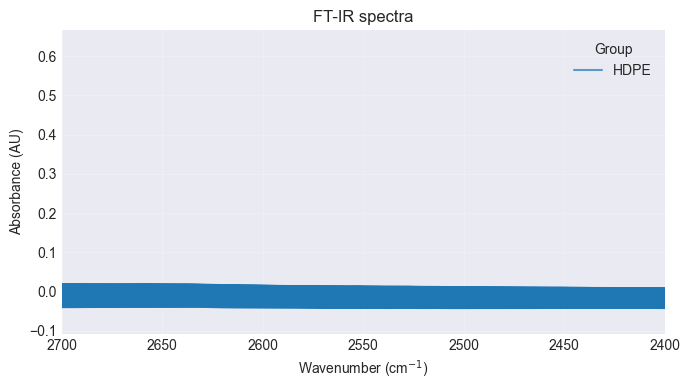

[2/6] LDPE (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 966.86it/s]


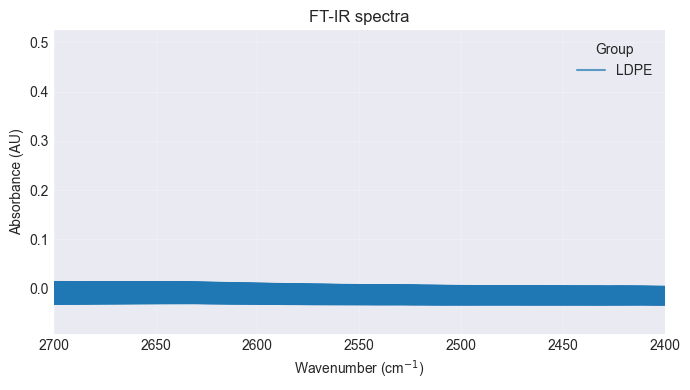

[3/6] PET (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 894.75it/s]


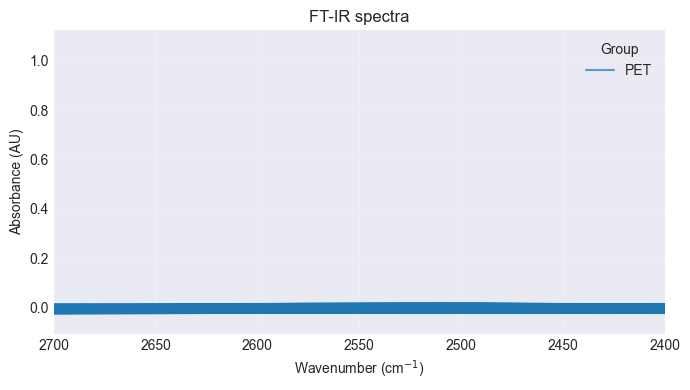

[4/6] PP (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 968.99it/s]


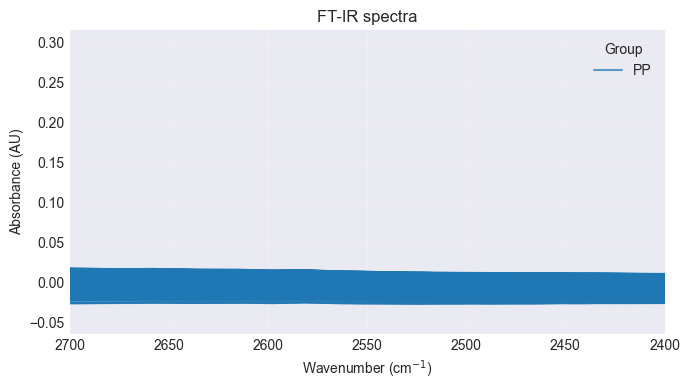

[5/6] PS (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 888.03it/s]


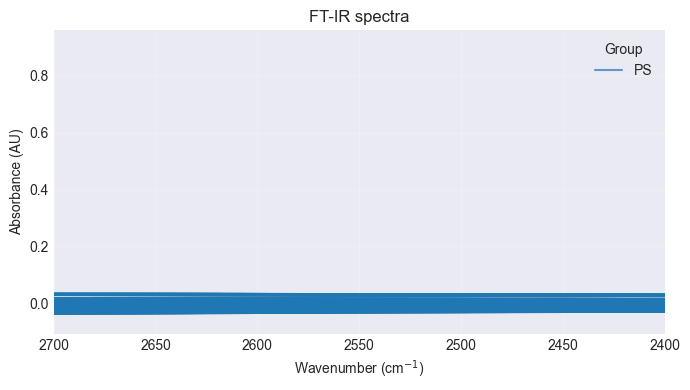

[6/6] PVC (500 samples)
Auto-detected: Absorbance


100%|██████████| 500/500 [00:00<00:00, 987.37it/s] 


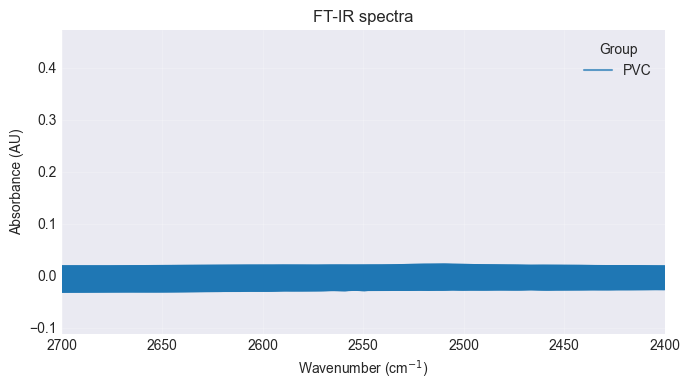

In [4]:
print(f"Inspecting flat window 2400-2700 cm⁻¹ for {len(labels)} polymer types\n")

# Plot each polymer type in the second flat window
for i, label in enumerate(labels, 1):
    # Filter data for current polymer type
    if is_polars:
        df_label = df_denoised.filter(pl.col(LABEL_COLUMN) == label)
    else:
        df_label = df_denoised[df_denoised[LABEL_COLUMN] == label]
    
    print(f"[{i}/{len(labels)}] {label} ({len(df_label)} samples)")
    
    # Plot spectra in the second flat window region
    fdp.plot(
        data=df_label,
        show_legend=True,
        color_by_group=True,
        x_min=2400,
        x_max=2700
    )

### Interpretation of Flat Window Plots

After viewing the plots above:
- ✅ **Good flat window**: Minimal peaks, relatively horizontal lines
- ⚠️ **Needs adjustment**: Significant peaks or features in the region
- 📊 **Baseline drift visible**: Sloped or curved baselines indicate need for correction

If your flat windows show significant peaks, consider modifying the `FLAT_WINDOWS` variable at the top of this notebook.

---

## Step 4: Evaluate All Baseline Correction Methods

Now we'll systematically evaluate all 50+ baseline correction methods for each polymer type using the flat windows defined above.

Starting baseline correction method evaluation

Evaluating 6 polymer types
Using flat windows: [(1880, 1900), (2400, 2700)]
Testing 50+ baseline correction methods


[1/6] Evaluating polymer type: HDPE
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]

##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


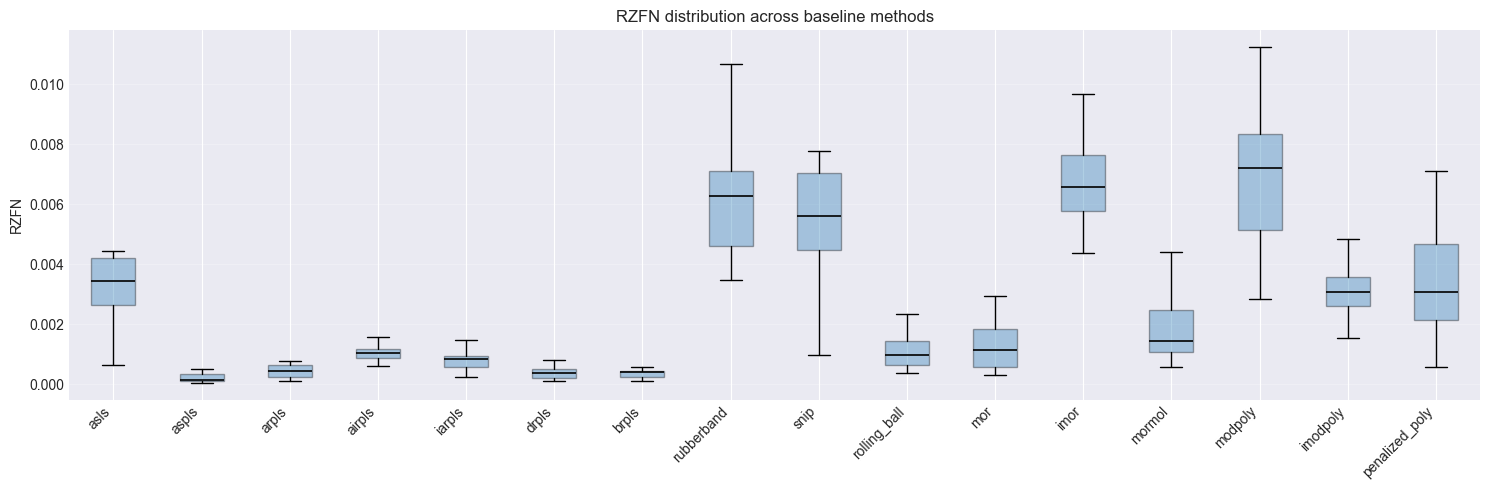

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


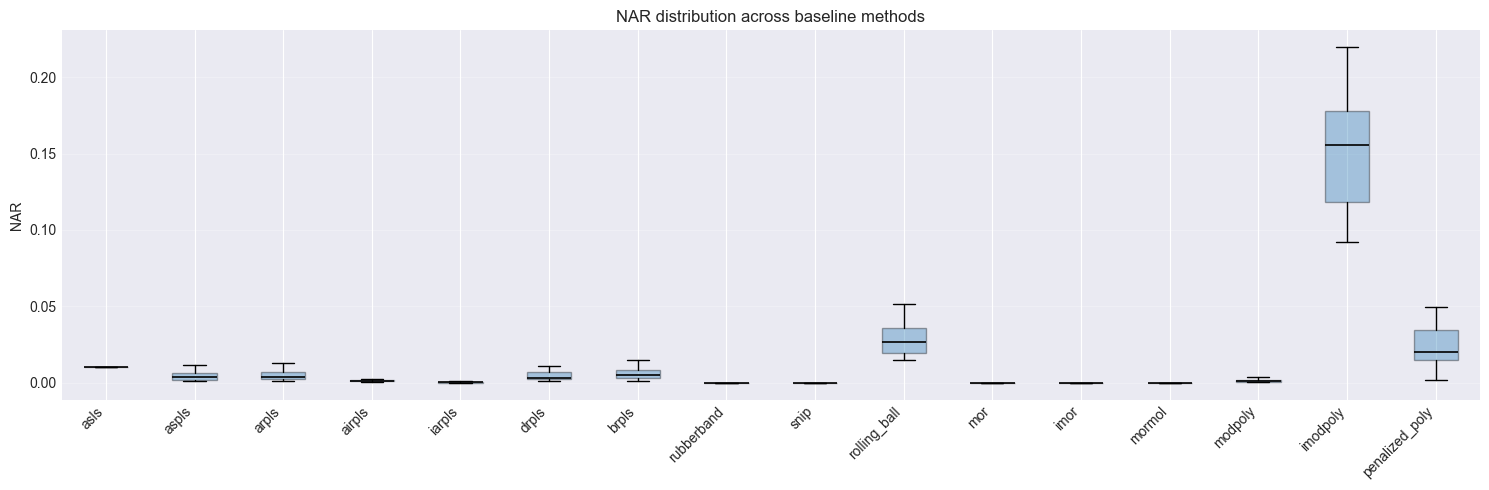

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


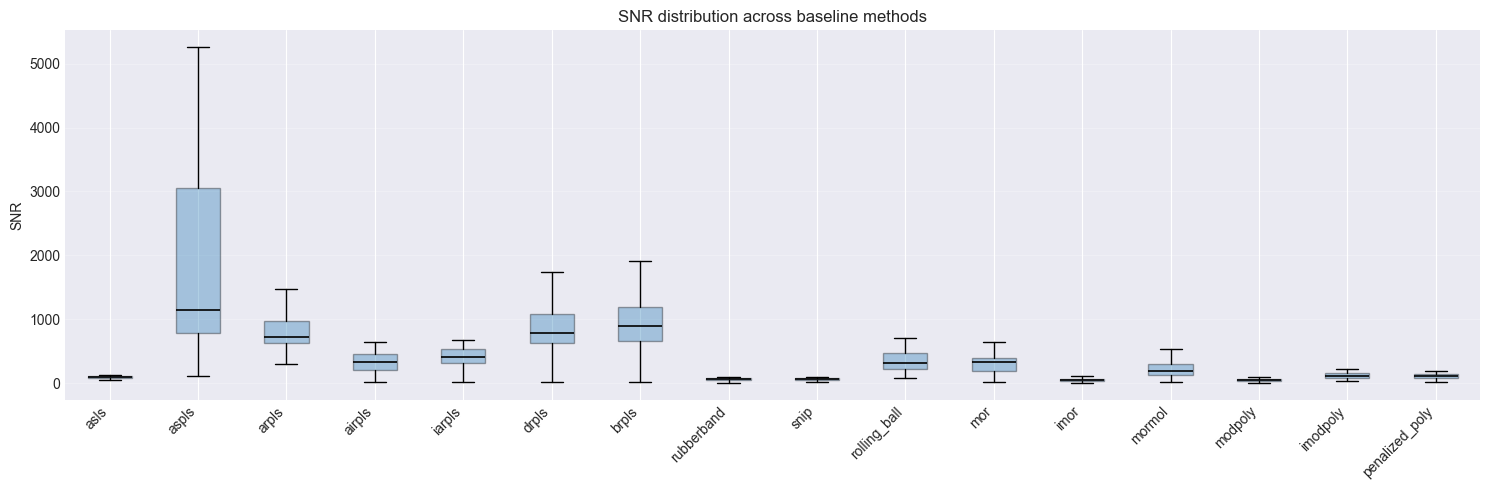


✓ Top method for HDPE: aspls
 Median RFZN: 0.0001, Median NAR: 0.0039, Median SNR: 1135.68

[2/6] Evaluating polymer type: LDPE
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:00<00:00, 83.22it/s]

##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


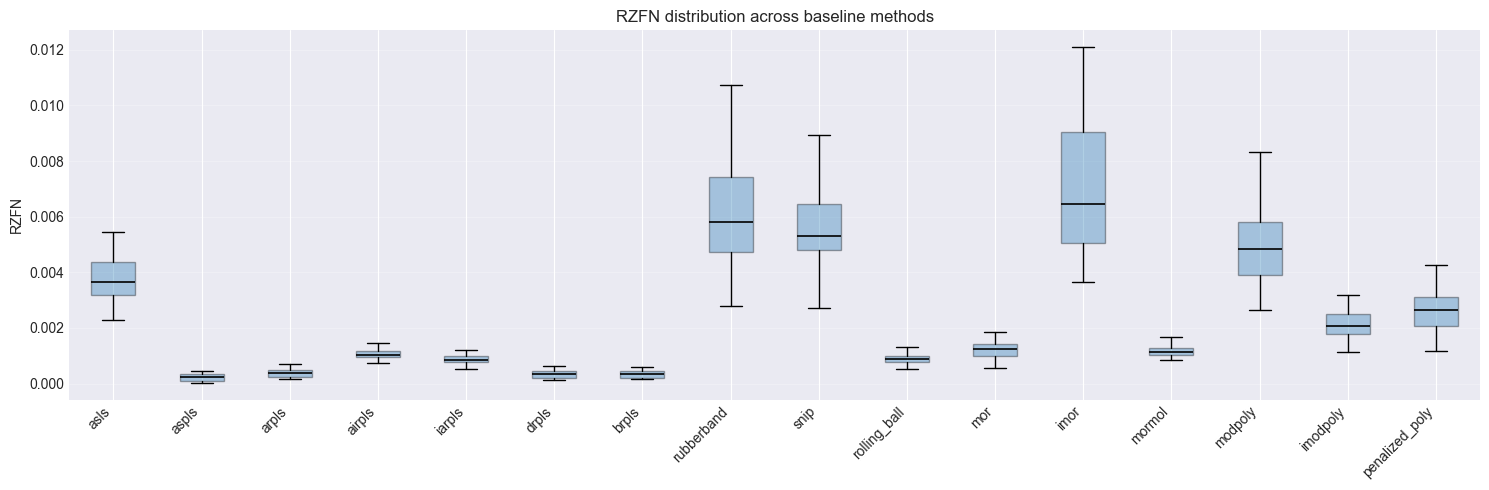

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


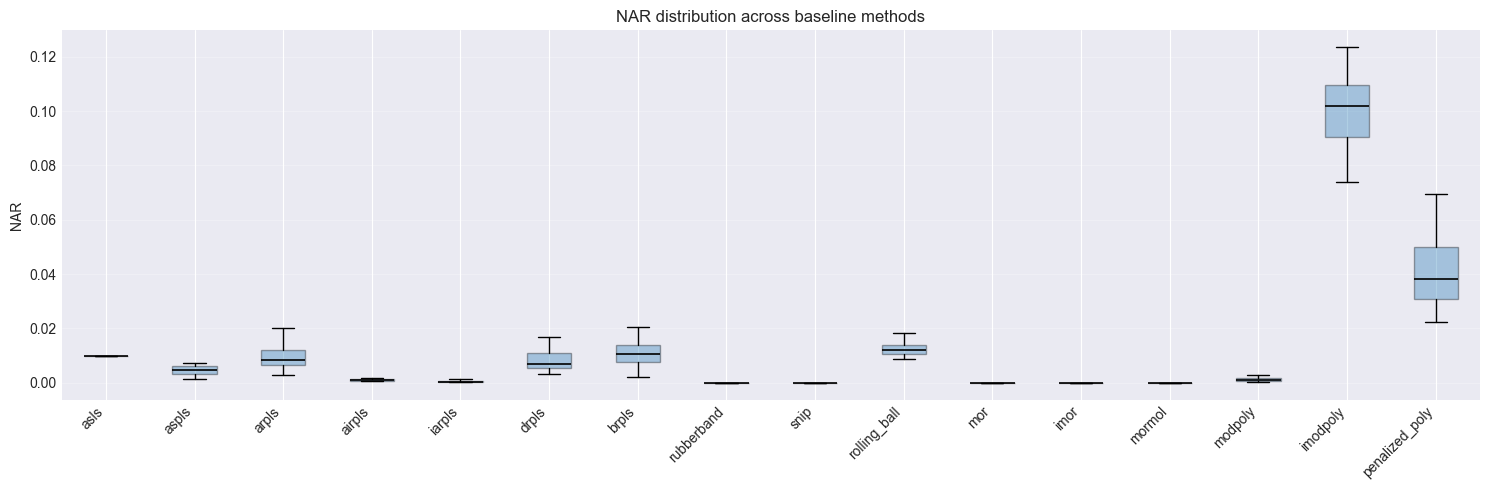

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


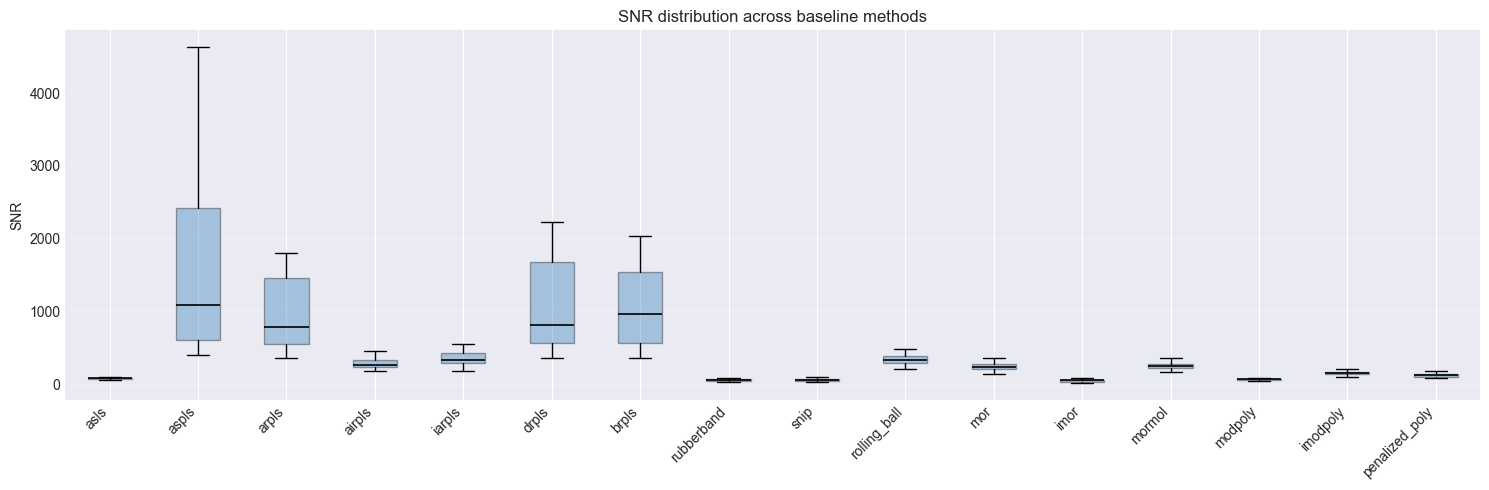


✓ Top method for LDPE: aspls
 Median RFZN: 0.0003, Median NAR: 0.0046, Median SNR: 1093.32

[3/6] Evaluating polymer type: PET
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:00<00:00, 66.25it/s]


##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


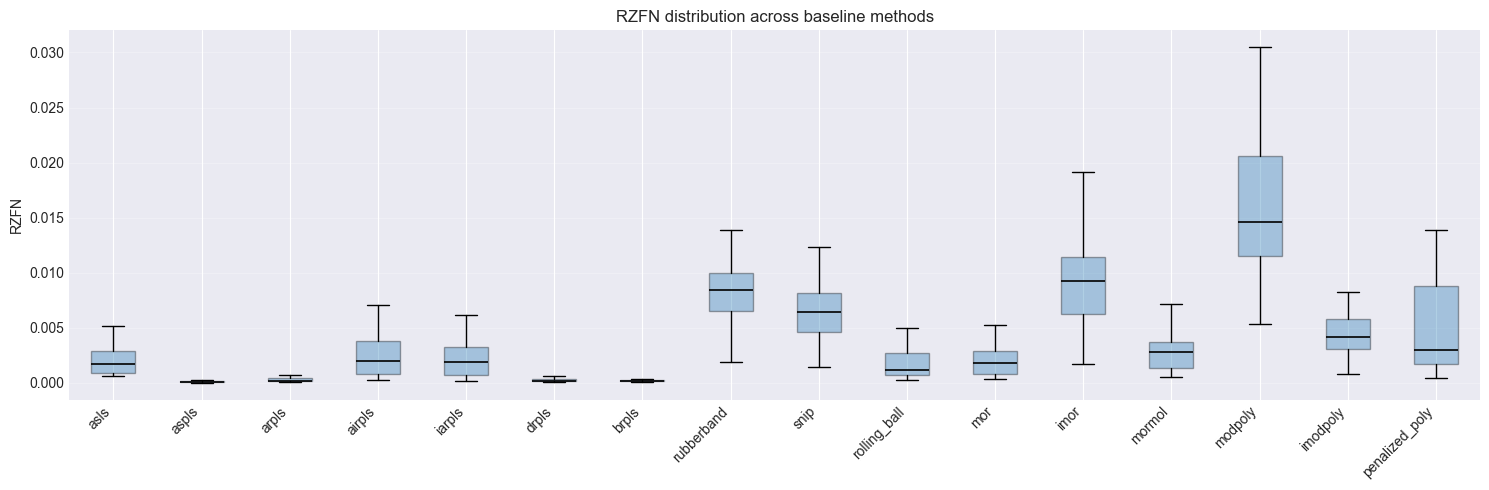

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


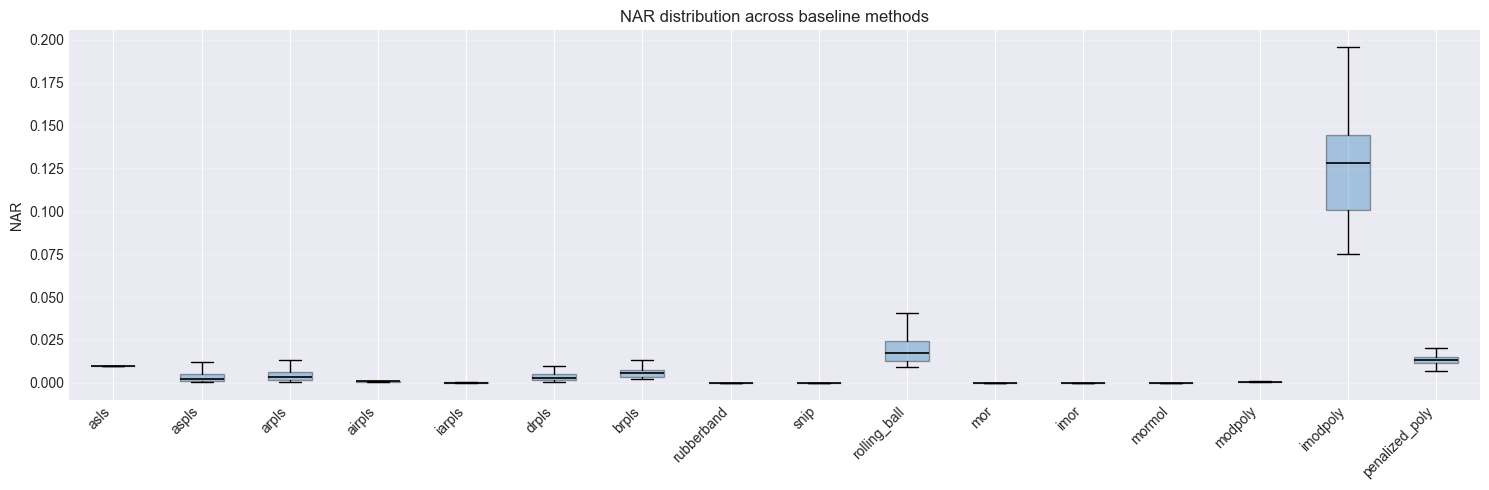

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


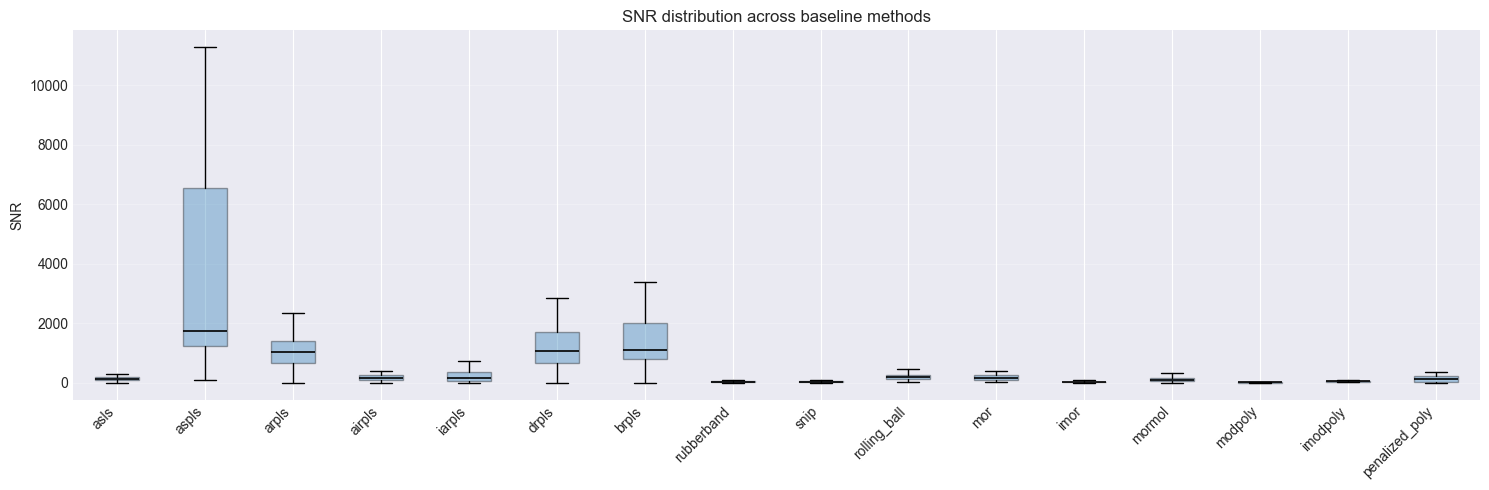


✓ Top method for PET: aspls
 Median RFZN: 0.0001, Median NAR: 0.0021, Median SNR: 1747.12

[4/6] Evaluating polymer type: PP
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:00<00:00, 87.96it/s]


##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


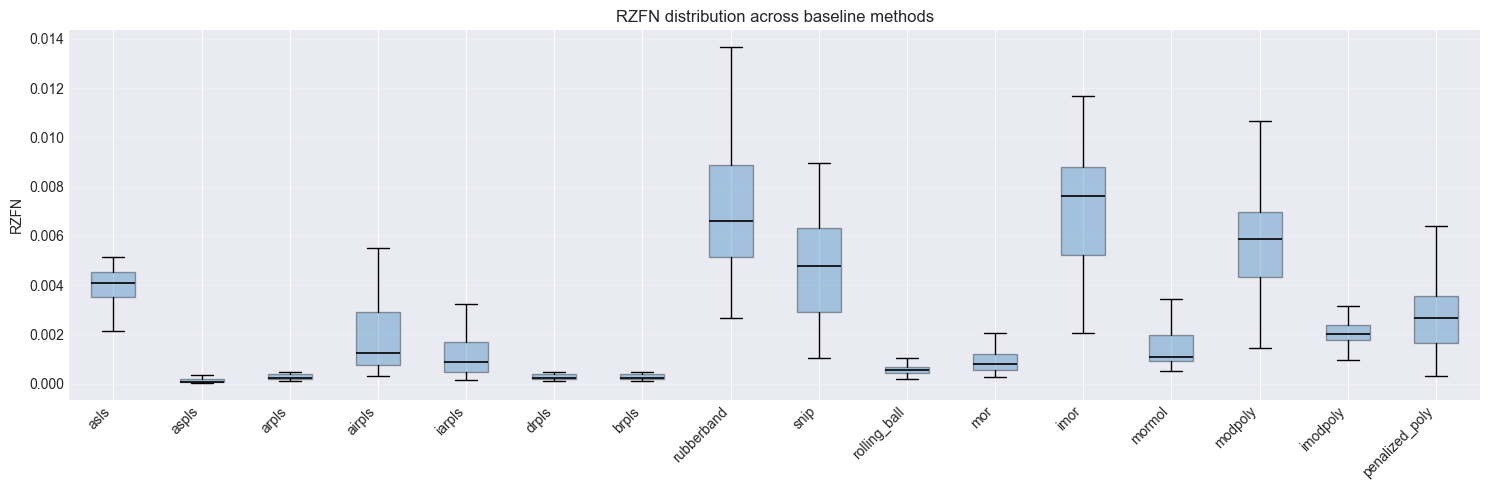

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


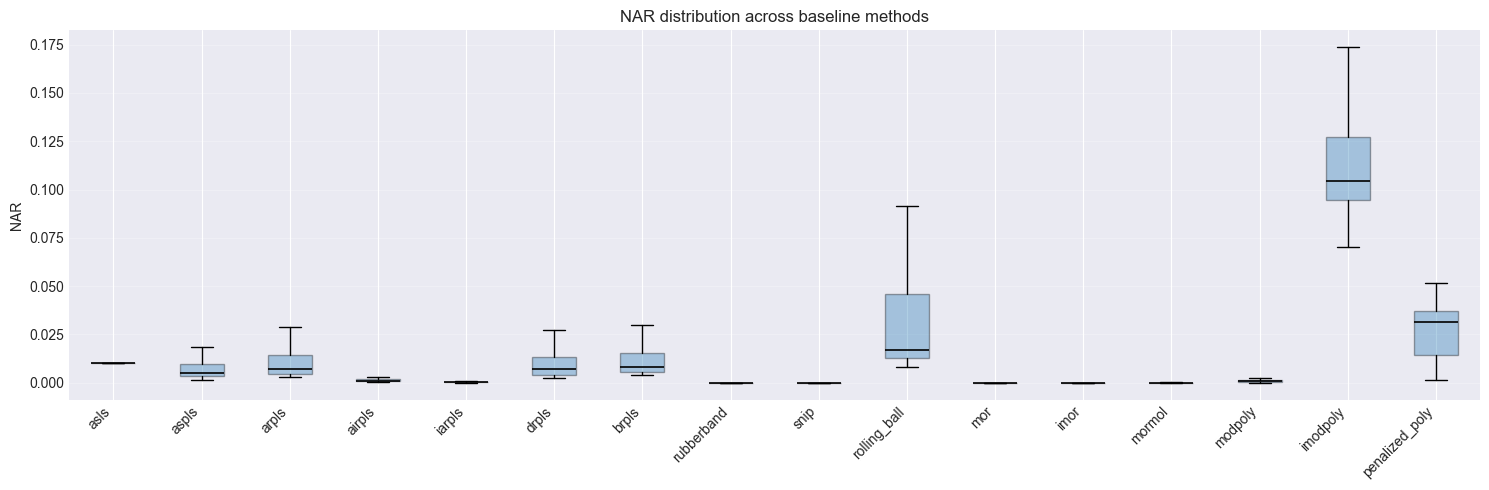

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


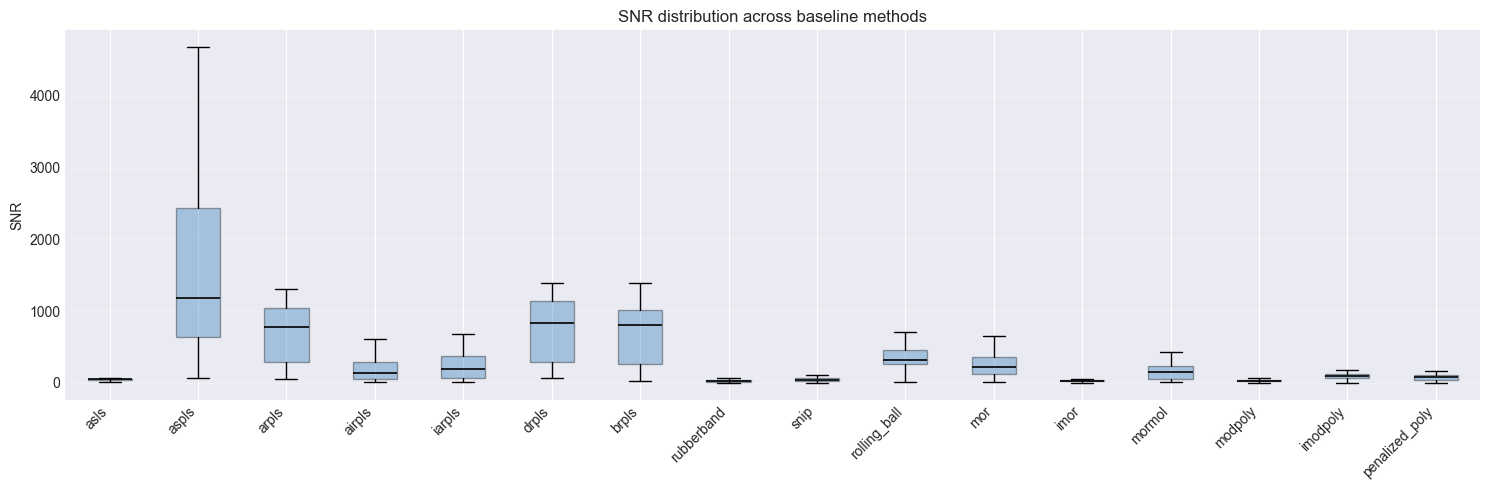


✓ Top method for PP: aspls
 Median RFZN: 0.0001, Median NAR: 0.0052, Median SNR: 1187.01

[5/6] Evaluating polymer type: PS
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:00<00:00, 77.25it/s]


##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


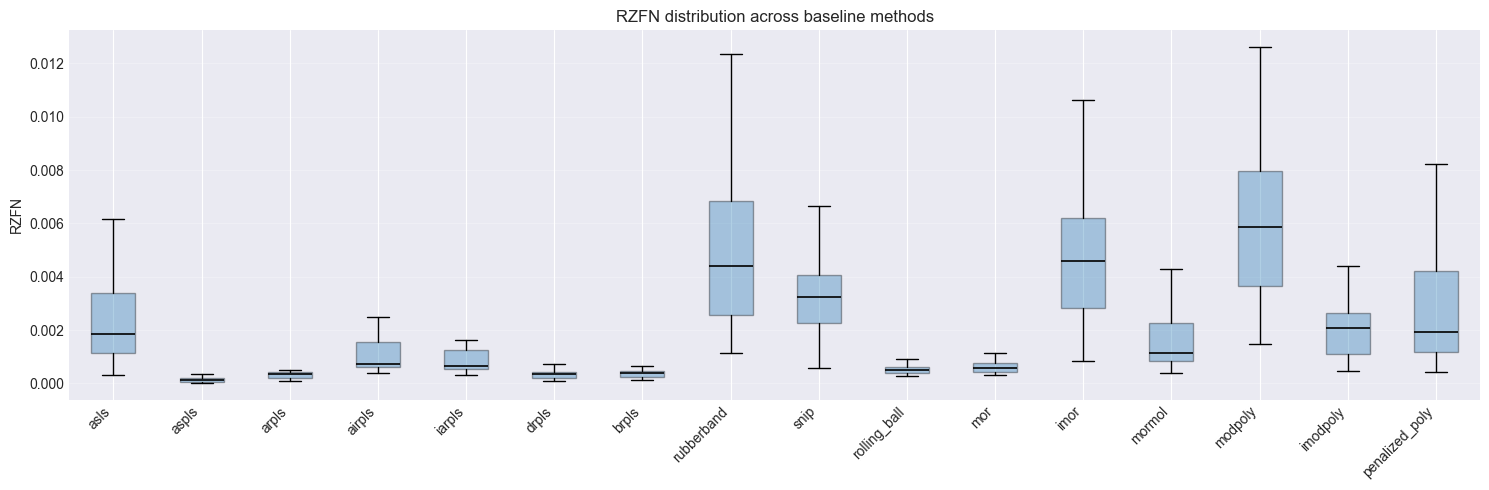

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


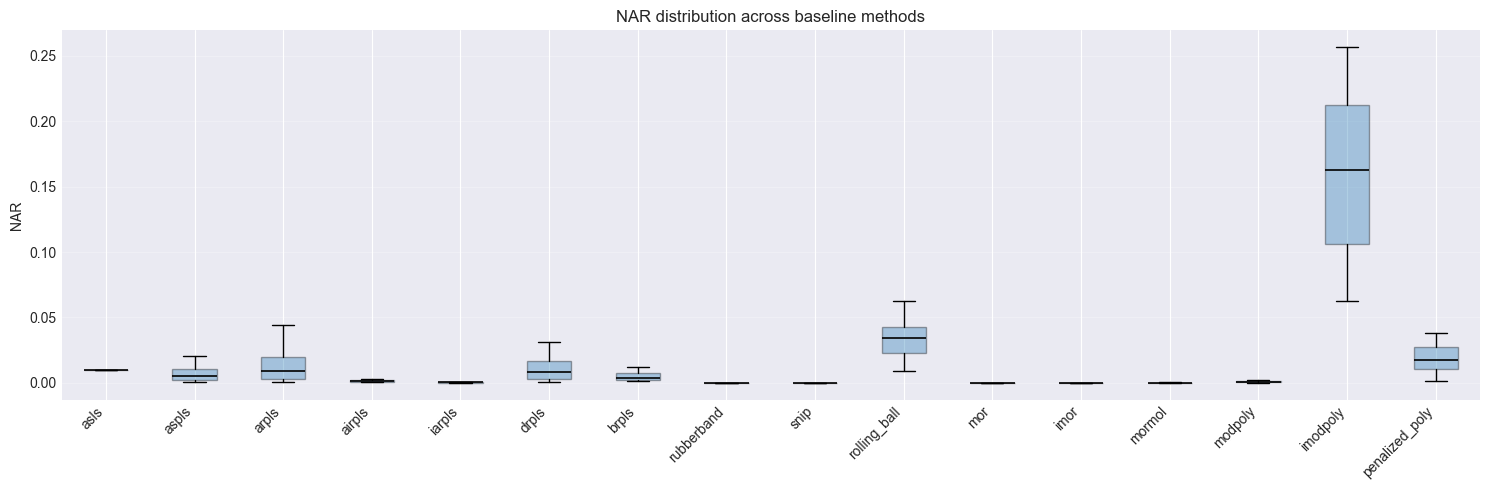

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


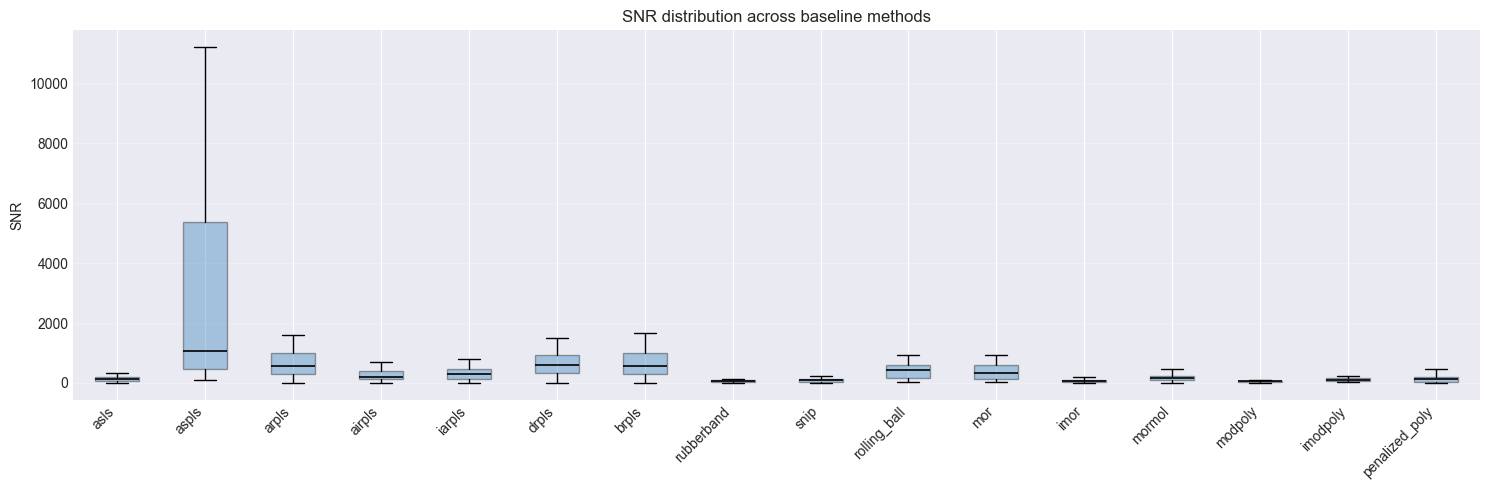


✓ Top method for PS: aspls
 Median RFZN: 0.0001, Median NAR: 0.0055, Median SNR: 1053.88

[6/6] Evaluating polymer type: PVC
Number of samples: 500


baseline eval: 100%|██████████| 50/50 [00:00<00:00, 72.79it/s]


##### Plotting Residual Flatness in Zero-Noise (RFZN) - lower is better ! #####


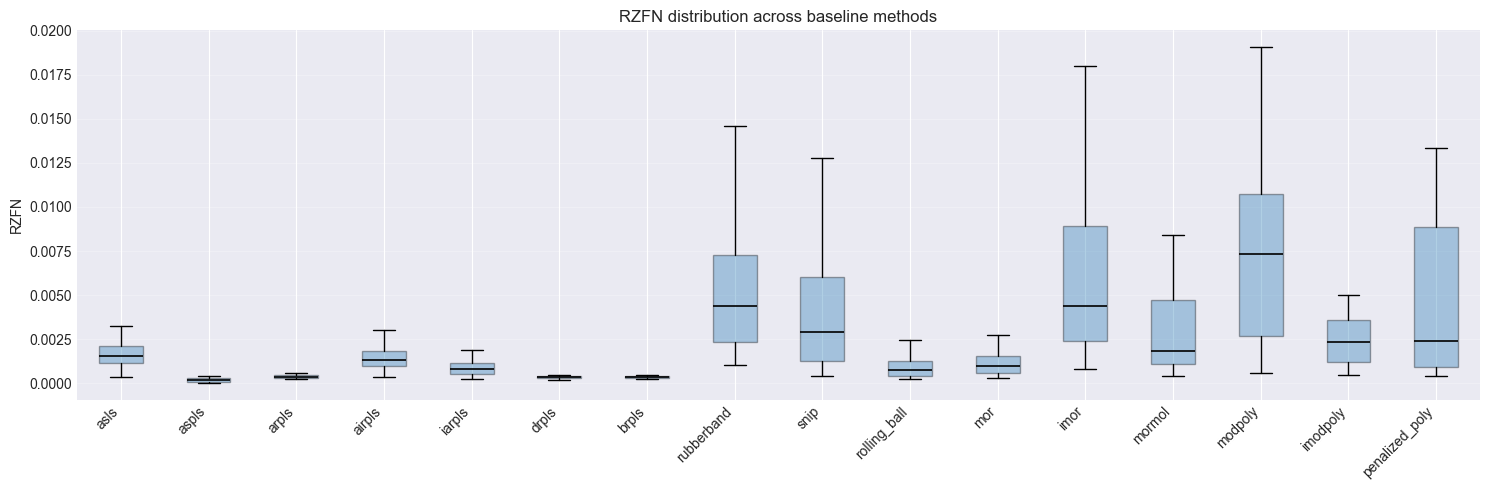

##### Plotting Negative Absorbance Ratio (NAR) - lower is better! #####


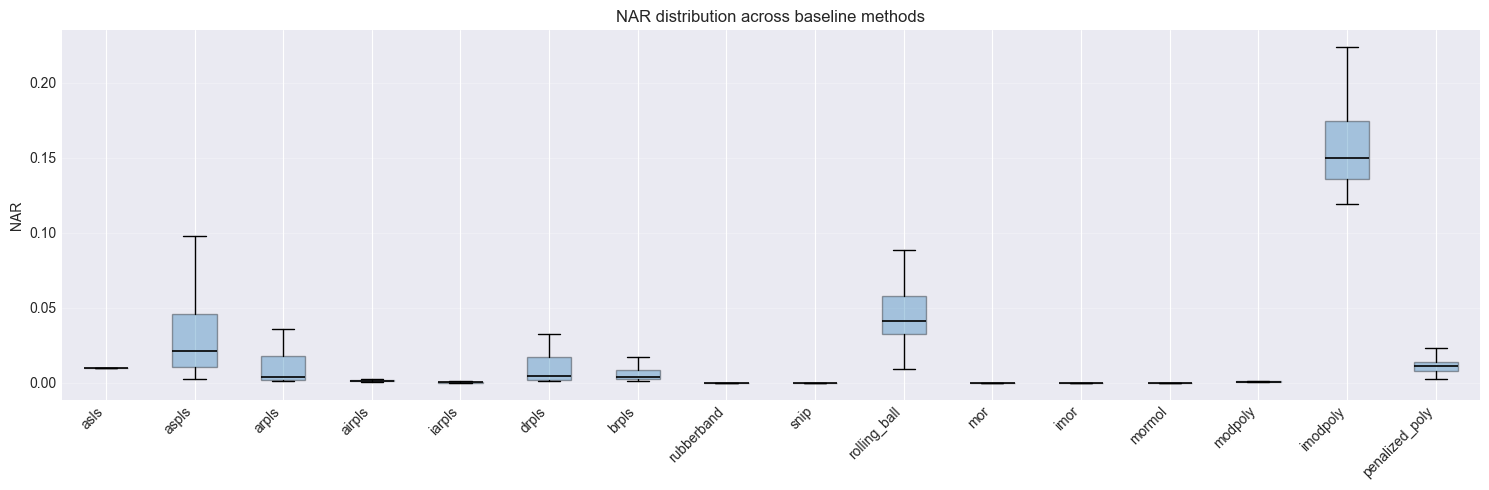

##### Plotting Signal-to-Noise Ratio (SNR) - higher is better! #####


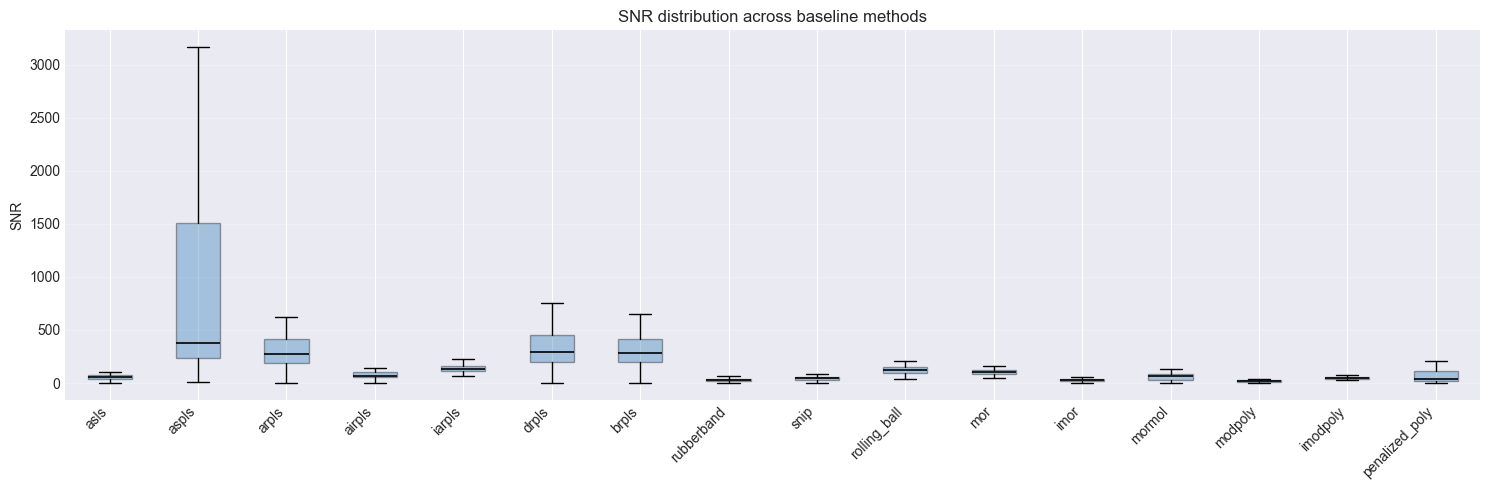


✓ Top method for PVC: aspls
 Median RFZN: 0.0002, Median NAR: 0.0214, Median SNR: 375.11

Combining results from all polymer types...

✓ Results saved to: baseline_correction_methods_scores.xlsx
Total evaluations: 96 (top 16 methods × 6 types)

SUMMARY: Top recommended method for each polymer type
HDPE                 → aspls           (Median RFZN: 0.0001, Median NAR: 0.004, Median SNR: 1135.7)
LDPE                 → aspls           (Median RFZN: 0.0003, Median NAR: 0.005, Median SNR: 1093.3)
PET                  → aspls           (Median RFZN: 0.0001, Median NAR: 0.002, Median SNR: 1747.1)
PP                   → aspls           (Median RFZN: 0.0001, Median NAR: 0.005, Median SNR: 1187.0)
PS                   → aspls           (Median RFZN: 0.0001, Median NAR: 0.006, Median SNR: 1053.9)
PVC                  → aspls           (Median RFZN: 0.0002, Median NAR: 0.021, Median SNR: 375.1)


In [ ]:
# Import pandas for results handling
import pandas as pd

print("="*80)
print("Starting baseline correction method evaluation")
print("="*80)
print(f"\nEvaluating {len(labels)} polymer types")
print(f"Using flat windows: {FLAT_WINDOWS}")
print(f"Testing 50+ baseline correction methods\n")

# Store results for all polymer types
all_results = []

# Evaluate baseline methods for each polymer type
for i, label in enumerate(labels, 1):
    print(f"\n{'='*80}")
    print(f"[{i}/{len(labels)}] Evaluating polymer type: {label}")
    print(f"{'='*80}")
    
    # Filter data for current polymer type
    if is_polars:
        df_label = df_denoised.filter(pl.col(LABEL_COLUMN) == label)
    else:
        df_label = df_denoised[df_denoised[LABEL_COLUMN] == label]
    
    print(f"Number of samples: {len(df_label)}")
    
    # Evaluate all FTIR baseline correction methods
    # This tests each method on n_samples random spectra
    # baseline_methods="FTIR" uses the recommended FTIR-specific methods
    # To evaluate all available method ues baseline_methods=None
    bs = fdp.find_baseline_method(
        data=df_label,
        flat_windows=FLAT_WINDOWS,
        baseline_methods="FTIR",
        n_samples=50
    )
    
    # Rank methods based on evaluation criteria
    # rfzn_threshold: Maximum acceptable relative flatness (0.05 = 5%)
    # nar_threshold: Minimum noise-to-artifact ratio (0.5 = 50%)
    # snr_min: Minimum signal-to-noise ratio (100)
    # top_n: Number of top methods to return (16)
    result = fdp.best_baseline_method(
        rfzn_threshold=0.05,
        nar_threshold=0.5,
        snr_min=100,
        top_n=16
    )
    
    # Add polymer type label to results
    result = result.copy()
    result["type"] = label
    all_results.append(result)

    print(f"\n✓ Top method for {label}: {result.iloc[0]['method']}")
    print(f" Median RFZN: {result.iloc[0]['median_rfzn']:.4f}, Median NAR: {result.iloc[0]['median_nar']:.4f}, "
          f"Median SNR: {result.iloc[0]['median_snr']:.2f}")

# Combine results from all polymer types
print("\n" + "="*80)
print("Combining results from all polymer types...")
print("="*80)

final_df = pd.concat(all_results, ignore_index=True)

# Save results to Excel file
output_file = 'baseline_correction_methods_scores.xlsx'
final_df.to_excel(output_file, index=False)

print(f"\n✓ Results saved to: {output_file}")
print(f"Total evaluations: {len(final_df)} (top {16} methods × {len(labels)} types)")

# Display summary
print("\n" + "="*80)
print("SUMMARY: Top recommended method for each polymer type")
print("="*80)
for label in labels:
    top_method = final_df[final_df["type"] == label].iloc[0]
    print(f"{label:20s} → {top_method['method']:15s} "
          f"(Median RFZN: {top_method['median_rfzn']:.4f}, Median NAR: {top_method['median_nar']:.3f}, "
          f"Median SNR: {top_method['median_snr']:.1f})")

### Understanding the Results

The evaluation process:

1. **Tests 50+ baseline methods** on 50 random samples from each polymer type
2. **Measures quality** using RFZN, NAR, and SNR metrics in flat windows
3. **Ranks methods** based on your quality thresholds
4. **Returns top 16** methods that meet all criteria

### How to Interpret the Metrics

- **RFZN (Relative Flatness in Zero-Noise regions)**:
  - **Lower is better** (closer to 0 means flatter)
  - Values <0.05 (5%) are excellent
  - Measures how flat the baseline is in regions that should be flat

- **NAR (Noise-to-Artifact Ratio)**:
  - **Higher is better**
  - Values >0.5 are recommended
  - Low NAR means the method introduces artifacts

- **SNR (Signal-to-Noise Ratio)**:
  - **Higher is better**
  - Values >100 are good, >200 are excellent
  - Overall signal quality after baseline correction

### Common Top Methods

- **asls (Asymmetric Least Squares)**: Robust general-purpose method
- **airpls (Adaptive Iteratively Reweighted Penalized Least Squares)**: Good for varied baselines
- **mor (Morphological)**: Fast and effective for smooth baselines
- **poly (Polynomial)**: Simple but effective for smooth drift
- **arpls (Asymmetrically Reweighted Penalized Least Squares)**: Balance of speed and quality

---

## Step 5: Optional - Save Denoised Data

If you want to save the denoised (but not baseline-corrected) data for later use:

In [6]:
# Optional: Save denoised spectra to Excel
# This can be useful for comparing preprocessing steps or for external analysis
output_denoised = 'denoised_spectra.xlsx'
df_denoised.to_excel(output_denoised, index=False)
print(f"✓ Denoised spectra saved to: {output_denoised}")

✓ Denoised spectra saved to: denoised_spectra.xlsx


---

## Next Steps

1. **Review the Excel file** `baseline_correction_methods_scores.xlsx` to see all ranked methods
2. **Check for consistency**: See if one method works well across all polymer types
3. **Choose your baseline method** based on the summary above
4. **Apply in your pipeline** using:
   ```python
   fdp.correct_baseline(method="asls")  # Replace "asls" with your chosen method
   ```

### Tips for Method Selection

- **Consistency is key**: If one method (e.g., `asls`) ranks highly for all polymer types, use it for the entire dataset
- **Different methods for different types**: If polymer types need different methods, process them separately
- **Trade-offs**:
  - `asls`, `airpls`: Excellent quality but slower
  - `mor`, `snip`: Fast but may not handle complex baselines
  - `poly`: Very fast, good for smooth baselines only

### Adjusting Thresholds

If no methods meet your criteria, you can relax the thresholds in the `best_baseline_method()` call:
- Increase `rfzn_threshold` (e.g., from 0.05 to 0.10)
- Decrease `nar_threshold` (e.g., from 0.5 to 0.3)
- Decrease `snr_min` (e.g., from 100 to 50)

---

## Conclusion

You've successfully evaluated 50+ baseline correction methods! The quantitative results will help you make an informed decision. Proceed to Notebook 3 to evaluate normalization methods.